# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle
import numpy as np
import cv2
import csv
import tensorflow as tf
import glob
import matplotlib.pyplot as plt

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

### Include an exploratory visualization of the dataset

In [5]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape =  (X_test.shape[1],  X_test.shape[1])
# TODO: How many unique classes/labels there are in the dataset.
n_classes = max(test['labels']) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [6]:
class_names = []
with open('signnames.csv','rt')as f:
    data = csv.reader(f)
    for row in data:
        sign_name = list(row)[1]
        if(sign_name != 'SignName'):
            class_names.append(sign_name)

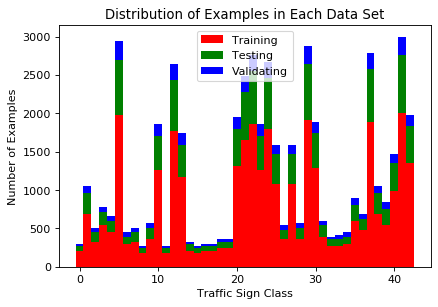

In [27]:
def print_distribution(y_train, y_test, y_valid):
    distribution = {}
    sign_class = []
    sign_num = [[],[],[]]
    
    for image in y_train:
        if(distribution.get(class_names[image]) != None):
            distribution[class_names[image]][0] = distribution[class_names[image]][0] + 1
        else:
            distribution[class_names[image]] = [0,0,0]
            
    for image in y_test:
        if(distribution.get(class_names[image]) != None):
            distribution[class_names[image]][1] = distribution[class_names[image]][1] + 1
        else:
            distribution[class_names[image]] = [0,0,0]
    
    for image in y_valid:
        if(distribution.get(class_names[image]) != None):
            distribution[class_names[image]][2] = distribution[class_names[image]][2] + 1
        else:
            distribution[class_names[image]] = [0,0,0]
            
    for x in distribution:
        sign_class.append(x)
        sign_num[0].append(distribution[x][0])
        sign_num[1].append(distribution[x][1])
        sign_num[2].append(distribution[x][2])
        
    n_classes = range(len(sign_class))
    width = 1
    plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    p1 = plt.bar(n_classes, sign_num[0], width, color='r')
    p2 = plt.bar(n_classes, sign_num[1], width, bottom=sign_num[0], color='g')
    p3 = plt.bar(n_classes, sign_num[2], width, 
             bottom=np.array(sign_num[0])+np.array(sign_num[1]), color='b')
    plt.ylabel('Number of Examples')
    plt.xlabel('Traffic Sign Class')
    plt.title('Distribution of Examples in Each Data Set')
    plt.legend((p1[0], p2[0], p3[0]), ('Training', 'Testing', 'Validating'), loc='upper center')
    plt.show()
    
print_distribution(y_train, y_test, y_valid)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
def normalise(images):
    return images/255

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = unison_shuffled_copies(X_train, y_train)
X_train = normalise(X_train)
X_valid = normalise(X_valid)
X_test = normalise(X_test)

### Model Architecture

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
EPOCHS = 10
history = model.fit(
    x = X_train,
    y = y_train,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 97s 3ms/sample - loss: 2.2321 - accuracy: 0.3343 - val_loss: 1.1945 - val_accuracy: 0.6238
Epoch 2/10
34799/34799 [==============================] - 96s 3ms/sample - loss: 0.7412 - accuracy: 0.7477 - val_loss: 0.4354 - val_accuracy: 0.8560
Epoch 3/10
34799/34799 [==============================] - 100s 3ms/sample - loss: 0.3613 - accuracy: 0.8807 - val_loss: 0.2686 - val_accuracy: 0.9150
Epoch 4/10
34799/34799 [==============================] - 77s 2ms/sample - loss: 0.2449 - accuracy: 0.9212 - val_loss: 0.2055 - val_accuracy: 0.9351
Epoch 5/10
34799/34799 [==============================] - 68s 2ms/sample - loss: 0.1983 - accuracy: 0.9363 - val_loss: 0.2035 - val_accuracy: 0.9313
Epoch 6/10
34799/34799 [==============================] - 73s 2ms/sample - loss: 0.1666 - accuracy: 0.9470 - val_loss: 0.1996 - val_accuracy: 0.9429
Epoch 7/10
34799/34799 [==============================] 

---

## Step 3: Test a Model on New Images

### Load and Output the Images and Predict the Sign Type for Each Image

Speed limit (70km/h)


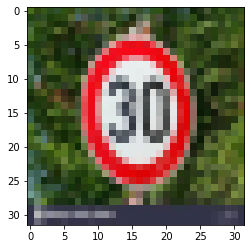

Bumpy road


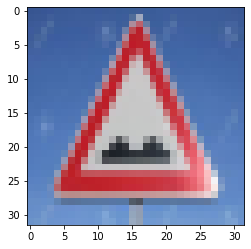

Speed limit (70km/h)


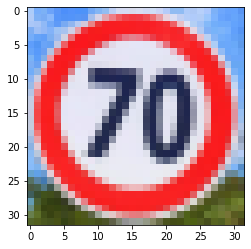

Keep right


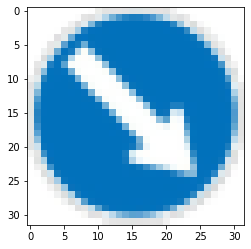

Stop


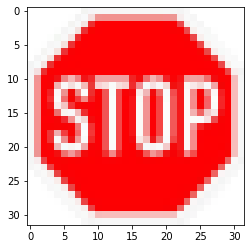

Dangerous curve to the left


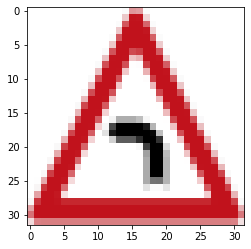

General caution


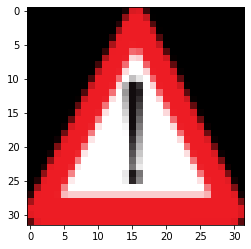

In [11]:
imgs = glob.glob('test_images/*.jpg')
imgs.extend(glob.glob('test_images/*.png'))

for img in imgs:
    cv_image = cv2.imread(img)
    image = cv_image[...,::-1]
    image = cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA)
    arr = np.array([image], dtype=np.float64)
    plt.imshow(image, cmap='binary')
    print(class_names[model.predict(arr).argmax()])
    plt.show()

### Analyze Performance

In [12]:
test_loss, test_accuracy = model.evaluate(x=X_test, y=y_test)

12630/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [17]:
def print_class_name(array, values):
    print(values)
    for i, elem in enumerate(array):
        print(i+1, class_names[elem], ' ', end="", flush=True)
    print()

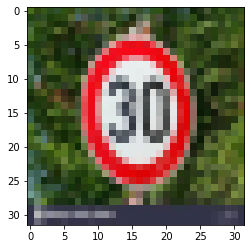

tf.Tensor([9.9999940e-01 6.4220234e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00], shape=(5,), dtype=float32)
1 Speed limit (70km/h)  2 Speed limit (20km/h)  3 Speed limit (30km/h)  4 Speed limit (50km/h)  5 Speed limit (60km/h)  


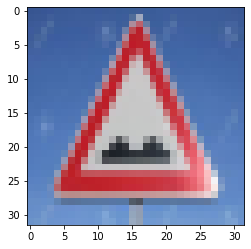

tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
1 Bumpy road  2 Speed limit (20km/h)  3 Speed limit (30km/h)  4 Speed limit (50km/h)  5 Speed limit (60km/h)  


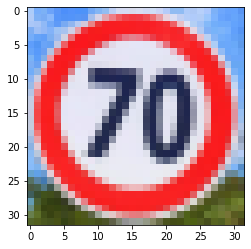

tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
1 Speed limit (70km/h)  2 Speed limit (20km/h)  3 Speed limit (30km/h)  4 Speed limit (50km/h)  5 Speed limit (60km/h)  


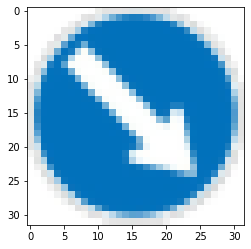

tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
1 Keep right  2 Speed limit (20km/h)  3 Speed limit (30km/h)  4 Speed limit (50km/h)  5 Speed limit (60km/h)  


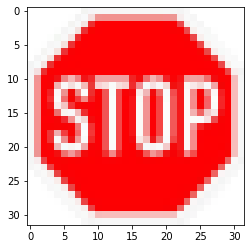

tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
1 Stop  2 Speed limit (20km/h)  3 Speed limit (30km/h)  4 Speed limit (50km/h)  5 Speed limit (60km/h)  


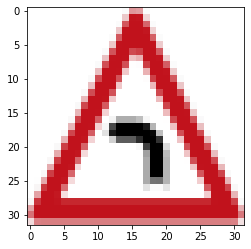

tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
1 Dangerous curve to the left  2 Speed limit (20km/h)  3 Speed limit (30km/h)  4 Speed limit (50km/h)  5 Speed limit (60km/h)  


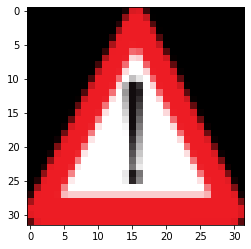

tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
1 General caution  2 Speed limit (20km/h)  3 Speed limit (30km/h)  4 Speed limit (50km/h)  5 Speed limit (60km/h)  


In [18]:
imgs = glob.glob('test_images/*.jpg')
imgs.extend(glob.glob('test_images/*.png'))

for i, img in enumerate(imgs):
    cv_image = cv2.imread(img)
    image = cv_image[...,::-1] #convert image to RGB which is our image format
    image = cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) #resize test image to shape of our input model
    arr = np.array([image], dtype=np.float64)
    prediction = model.predict(arr)
    prediction = tf.squeeze(prediction).numpy()
    values = tf.nn.top_k(tf.constant(prediction), k=5).values
    test = tf.nn.top_k(tf.constant(prediction), k=5).indices
    plt.imshow(image)
    plt.show()
    print_class_name(test, values)

### Project Writeup

Explained in the [README](./README.md)

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")